### Building a Podcast Summarizer using GPT-3

In [23]:
import whisper
import pandas as pd
from pytube import YouTube
import openai
import numpy as np
import tiktoken


Checking for the different types of models, it is interesting to see the different sizes for the 'Whisper Models' provided by OpenAI - https://github.com/openai/whisper/blob/main/model-card.md 

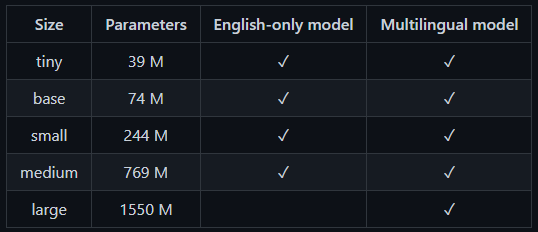

Here their definition by OpenAI: The Whisper models are trained for speech recognition and translation tasks, capable of transcribing speech audio into the text in the language it is spoken (ASR) as well as translated into English (speech translation). Researchers at OpenAI developed the models to study the robustness of speech processing systems trained under large-scale weak supervision. There are 9 models of different sizes and capabilities, summarized in the following table.

In this case we will utilize the 'base' model. 

In [6]:
model = whisper.load_model('base')

##### Retrieving Youtube's URL
Here we will be using MKBHD's video for reference : https://www.youtube.com/watch?v=cneoANZKBGk

In [7]:
def retrieve_youtube_url():
    url = input('\nPlease enter your Youtube URL of choice and press enter\nTo exit, type "F" and press enter')
    print('\nHere your URL: ', url)
    return url
yt_url = retrieve_youtube_url()
youtube_video = YouTube(yt_url)


Here your URL:  https://www.youtube.com/watch?v=cneoANZKBGk


In [8]:
# Display all the relevant attributes/directories regarding the video
dir(youtube_video)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_age_restricted',
 '_author',
 '_embed_html',
 '_fmt_streams',
 '_initial_data',
 '_js',
 '_js_url',
 '_metadata',
 '_player_config_args',
 '_publish_date',
 '_title',
 '_vid_info',
 '_watch_html',
 'age_restricted',
 'allow_oauth_cache',
 'author',
 'bypass_age_gate',
 'caption_tracks',
 'captions',
 'channel_id',
 'channel_url',
 'check_availability',
 'description',
 'embed_html',
 'embed_url',
 'fmt_streams',
 'from_id',
 'initial_data',
 'js',
 'js_url',
 'keywords',
 'length',
 'metadata',
 'publish_date',
 'rating',
 'register_on_complete_callback',
 'register_on_progress_callback',
 'stream_monostate',
 'streamin

In [9]:
# Obtaining only the audio
streams = youtube_video.streams.filter(only_audio=True)
streams

[<Stream: itag="139" mime_type="audio/mp4" abr="48kbps" acodec="mp4a.40.5" progressive="False" type="audio">, <Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2" progressive="False" type="audio">, <Stream: itag="249" mime_type="audio/webm" abr="50kbps" acodec="opus" progressive="False" type="audio">, <Stream: itag="250" mime_type="audio/webm" abr="70kbps" acodec="opus" progressive="False" type="audio">, <Stream: itag="251" mime_type="audio/webm" abr="160kbps" acodec="opus" progressive="False" type="audio">]

In [10]:
# Downloading audio into directory
stream = streams.first()
stream.download(filename='audios.mp4')

'c:\\Users\\ismae\\Personal-Projects\\Youtube-GPT\\audios.mp4'

In [11]:
output = model.transcribe(r'C:\Users\ismae\Personal-Projects\Youtube-GPT\audios.mp4')
output

C:\Users\ismae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\whisper\transcribe.py:79: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


{'text': " Hey, what's up, my KBHD here. So this little machine, this one right here that I can hold in my hands has more power than a base Mac Pro right now, more CPU power anyway. Now I hope that that's not true for much longer because the Mac Pro is overdue for its Apple Silicon upgrade. But the fact that it's true at all right now is absolutely insane. This little machine is not only super powerful and super efficient and super small, but it's also a really good price. So I said in my last video about the MacBook Pros that the Mac Mini is actually the more interesting machine. And I mean it, it really is. It's just gotten a refresh from the M1 chip that it had before to now having an M2 and an M2 Pro option, both of which are kind of game changers in their own ways. So first the M2 version, the base M2 Mac Mini is a game changer because it's all the benefits of the new Apple Silicon stuff, the second generation 5 and 8 meter process, the blazing fast shared memory, all the optimiza

#### Preparing the transcripted text from the video for GPT-3 fine-tuning

In [12]:
from transformers import GPT2TokenizerFast

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    """count the number of tokens in a string"""
    return len(tokenizer.encode(text))

video = 'MKBHD Apple Video'
res = []
segments = output['segments']
for segment in segments:
    res.append(('MKBHD Apple Video', segment['id'], segment['text'], count_tokens(segment['text'])))

df = pd.DataFrame(res, columns=["title", "heading", "content", "tokens"])
df.sample(10)

,title,heading,content,tokens
159,MKBHD Apple Video,159,"And then within each lineup, of course, I kee...",19
116,MKBHD Apple Video,116,fledgling creator with not a lot of space and...,17
74,MKBHD Apple Video,74,"on a chip starts at 1990, 99 right now.",11
109,MKBHD Apple Video,109,that I did back in college.,7
24,MKBHD Apple Video,24,And when the Mac Mini moved to Apple Silicon ...,18
76,MKBHD Apple Video,76,And that's the real reason I'm calling these ...,22
19,MKBHD Apple Video,19,"It's basically the laptop, but without the sc...",14
8,MKBHD Apple Video,8,So I said in my last video about the MacBook ...,19
25,MKBHD Apple Video,25,hilarious leap up in performance.,6
90,MKBHD Apple Video,90,It's just been sitting with the unupgraded M1...,21


#### Computing the segments of the transcript & specific query embeddings

In [17]:
EMBEDDING_MODEL = "text-embedding-ada-002"
openai.api_key = 'x'

Function explanation:

compute_doc_embeddings(): Create an embedding for each row in the dataframe using the OpenAI Embeddings API. Return a dictionary that maps between each embedding vector and the index of the row that it corresponds to.

In [37]:
def get_embedding(text: str, model: str=EMBEDDING_MODEL) -> list[float]:
    result = openai.Embedding.create(
      model=model,
      input=text
    )
    return result["data"][0]["embedding"]

def compute_doc_embeddings(df: pd.DataFrame) -> dict[tuple[str, str], list[float]]:
    return {
        idx: get_embedding(r.content) for idx, r in df.iterrows()
    }

video_embeddings = compute_doc_embeddings(df)

In [38]:
# An example embedding:
example_entry = list(video_embeddings.items())[0]
print(f"{example_entry[0]} : {example_entry[1][:5]}... ({len(example_entry[1])} entries)")

0 : [-0.01549014076590538, 0.005196060054004192, 0.013921518810093403, -0.039137113839387894, -0.0023480309173464775]... (1536 entries)


#### Finding the most similar segment of the video embeddings to the question embedding

vector_similarity(): Returns the similarity between two vectors. Because OpenAI Embeddings are normalized to length 1, the cosine similarity is the same as the dot product.

order_document_sections_by_query_similarity(): Find the query embedding for the supplied query, and compare it against all of the pre-calculated document embeddings to find the most relevant sections. Return the list of document sections, sorted by relevance in descending order.

In [21]:
def vector_similarity(x: list[float], y: list[float]) -> float:
    
    return np.dot(np.array(x), np.array(y))

def order_document_sections_by_query_similarity(query: str, contexts: dict[(str, str), np.array]) -> list[(float, (str, str))]:
    
    query_embedding = get_embedding(query)
    
    document_similarities = sorted([
        (vector_similarity(query_embedding, doc_embedding), doc_index) for doc_index, doc_embedding in contexts.items()
    ], reverse=True)
    
    return document_similarities

In [22]:
order_document_sections_by_query_similarity("What is the Mac Mini?", video_embeddings)[:5]

[(0.8532579990130094, 142),
 (0.8488487976721378, 80),
 (0.8476153252892457, 166),
 (0.8438641904334057, 37),
 (0.8193416718459371, 95)]

#### Construct a proper query prompt to answer a specific question

In [24]:
MAX_SECTION_LEN = 500
SEPARATOR = "\n* "
ENCODING = "gpt2"  # encoding for text-davinci-003

encoding = tiktoken.get_encoding(ENCODING)
separator_len = len(encoding.encode(SEPARATOR))

f"Context separator contains {separator_len} tokens"

'Context separator contains 3 tokens'

In [25]:
def construct_prompt(question: str, context_embeddings: dict, df: pd.DataFrame) -> str:
    
    most_relevant_document_sections = order_document_sections_by_query_similarity(question, context_embeddings)
    
    chosen_sections = []
    chosen_sections_len = 0
    chosen_sections_indexes = []
     
    for _, section_index in most_relevant_document_sections:
        # Add contexts until we run out of space.        
        document_section = df.loc[section_index]
        
        chosen_sections_len += document_section.tokens + separator_len
        if chosen_sections_len > MAX_SECTION_LEN:
            break
            
        chosen_sections.append(SEPARATOR + document_section.content.replace("\n", " "))
        chosen_sections_indexes.append(str(section_index))
            
    # Useful diagnostic information
    print(f"Selected {len(chosen_sections)} video sections from database:")
    print("\n".join(chosen_sections_indexes))
    
    header = """Answer the question as truthfully as possible using the provided context, and if the answer is not contained within the text below, say "I don't know."\n\nContext:\n"""
    
    return header + "".join(chosen_sections) + "\n\n Q: " + question + "\n A:"

In [26]:
prompt = construct_prompt(
    "What is the Mac Mini?",
    video_embeddings,
    df
)

print("===\n", prompt)

Selected 26 document sections:
142
80
166
37
95
167
113
29
55
118
145
89
2
13
108
19
88
151
101
138
21
137
12
52
18
9
===
 Answer the question as truthfully as possible using the provided context, and if the answer is not contained within the text below, say "I don't know."

Context:

*  default to the Mac Mini and just start with the base M2 599 Mac Mini.
*  And then here's the Mac Minis, which is the same performance, but for less money.
*  Mac mini, kind of a huge winner.
*  And so then we also have the M2 Pro Mac Mini.
*  But yeah, the Mac Mini now slots in really nicely underneath all of that.
*  Mac mini might make me miss removable memory, but it makes most massive media machines
*  capable, tiny machine for a college dorm room where space is at a premium.
*  So this M1 Mac Mini is already dramatically better than the Intel one for 99% of people.
*  And on top of that, the thermal advantage potentially of a Mac Mini with active cooling
*  I had spent in total with the Mac and al

#### Answer the user's question based on the specific context

In [27]:
COMPLETIONS_MODEL = "text-davinci-003"

In [31]:
COMPLETIONS_API_PARAMS = {
    # We use temperature of 0.0 because it gives the most predictable, factual answer.
    "temperature": 1.0,
    "max_tokens": 300,
    "model": COMPLETIONS_MODEL,
}

In [32]:
def answer_query_with_context(
    query: str,
    df: pd.DataFrame,
    document_embeddings: dict[(str, str), np.array],
    show_prompt: bool = False
) -> str:
    prompt = construct_prompt(
        query,
        document_embeddings,
        df
    )
    
    if show_prompt:
        print(prompt)

    response = openai.Completion.create(
                prompt=prompt,
                **COMPLETIONS_API_PARAMS
            )

    return response["choices"][0]["text"].strip(" \n")

In [33]:
answer_query_with_context("What is the Mac Mini?", df, video_embeddings)

Selected 26 document sections:
142
80
166
37
95
167
113
29
55
118
145
89
2
13
108
19
88
151
101
138
21
137
12
52
18
9


'The Mac Mini is a small, capable computer with active cooling and a headphone jack. It has an M2 599 base version and an M2 Pro option, making it a game changer in its own ways. It is capable of massive media machines and is a great option for college dorm rooms where space is at a premium.'

#### Let's test some examples

In [34]:
query = "What is the price of the Mac Mini?"
answer = answer_query_with_context(query, df, video_embeddings)

print(f"\nQ: {query}\nA: {answer}")

Selected 26 document sections:
142
118
80
145
37
166
29
15
32
2
89
55
151
95
79
134
138
35
144
167
113
72
7
132
13
108

Q: What is the price of the Mac Mini?
A: The price of the Mac Mini starts at $599.


In [39]:
query = "What might be controversial about Apple?"
answer = answer_query_with_context(query, df, video_embeddings)

print(f"\nQ: {query}\nA: {answer}")

Selected 31 document sections:
89
23
88
4
69
138
12
79
166
2
101
137
87
167
165
147
151
55
52
104
171
29
82
139
124
135
9
102
80
18
106

Q: What might be controversial about Apple?
A: Apple's prioritization of laptops over desktops might be seen as controversial, as it has resulted in many of the desktop options not being upgraded for a long time.


: 